In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import pyplot
sns.set()
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import FunctionTransformer
from keras.layers import Dense, Dropout
from keras.models import Sequential
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from keras.optimizers import SGD
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion

import keras
from tensorflow.python import debug as tf_debug
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())
import import_ipynb
from Helpers import *
from PandasFeatureUnion import PandasFeatureUnion

Using TensorFlow backend.


importing Jupyter notebook from Helpers.ipynb
importing Jupyter notebook from PandasFeatureUnion.ipynb


/Users/drmegavolt/miniconda3/envs/home_iowa/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
train = pd.read_csv('train.csv', index_col='Id')
test = pd.read_csv('test.csv',index_col='Id')
test_ids = test.index
y_train = np.log(train['SalePrice'])
np.random.seed(1)

total_bath= lambda x: x.FullBath+x.HalfBath*0.5 +x.BsmtHalfBath*0.5+x.BsmtFullBath


bath_columns = ['FullBath','HalfBath','BsmtHalfBath', 'BsmtFullBath']
bath_pipeline = Pipeline([
    ('SelectBathColumns',  ColumnSelector(columns=bath_columns)),
    ('fillNaAsZero', FillNA(columns=bath_columns, fill_value=0)),
    ('combine', ApplyTransformer(fn=total_bath, name='Bath'))
]) 
  

important_columns = [
    'GrLivArea', 'YearBuilt', 'OverallQual','MSSubClass',
    'Neighborhood', 'SaleType'
]
# No improovement
# 'BldgType' 

cs = ColumnSelector(columns=important_columns)

scdt = DummiesTransformer(column='MSSubClass', keys=[ 20,  30,  40,  45,  50,  60,  70,  75,  80,  85,  90, 120, 150, 160, 180, 190])
oqdt = DummiesTransformer(column='OverallQual', keys=range(1,11))
neigbTrans = DummiesTransformer(column='Neighborhood', keys=["Blmngtn", "Blueste", "BrDale", "BrkSide", "ClearCr", "CollgCr", "Crawfor", "Edwards", "Gilbert", "IDOTRR", "MeadowV", "Mitchel", "Names", "NoRidge", "NPkVill", "NridgHt", "NWAmes", "OldTown", "SWISU", "Sawyer", "SawyerW", "Somerst", "StoneBr", "Timber", "Veenker"])
bdTypeTrans= DummiesTransformer(column='BldgType', keys=['1Fam', '2FmCon', 'Duplex', 'TwnhsE', 'TwnhsI'])
saleTypeTrans= DummiesTransformer(column='SaleType', keys=["WD","CWD","VWD","New","COD","Con","ConLw","ConLI","ConLD","Oth"])

core_pipeline = Pipeline(
    [('SelectColumns', cs),
     ('DummiesMSSubClass', scdt),
     ('OverallQual', oqdt),
     ('DummiesNeighborhood', neigbTrans),
     ('DummiesSaleType', saleTypeTrans) #('DummiesBldgType',bdTypeTrans)
    ])

pp = PandasFeatureUnion([
    ('bath',bath_pipeline),
    ('core', core_pipeline)], n_jobs=None)

X_train = pp.fit_transform(train)
X_test = pp.transform(test)
 

/Users/drmegavolt/miniconda3/envs/home_iowa/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/drmegavolt/miniconda3/envs/home_iowa/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/drmegavolt/miniconda3/envs/home_iowa/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [3]:
# define model
model = Sequential()
input_layer = Dense(50, input_dim=len(X_train.columns), activation='relu', kernel_initializer='normal') 
model.add(input_layer)

model.add(Dense(50, activation='relu', kernel_initializer='normal') )
# model.add(Dropout(rate=0.05))
model.add(Dense(1, activation='linear'))

optimizer = keras.optimizers.SGD() #Adam(lr=0.0015);
# compile model
model.compile(loss='mean_squared_error', optimizer=optimizer)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.
Restoring model weights from the end of the best epoch
Epoch 00145: early stopping
Train Error: 0.143, Test Error: 0.150


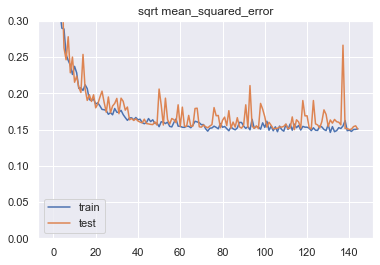

In [4]:

trainX, testX, trainy, testy = train_test_split(X_train, 
                                                    y_train, 
                                                    test_size=0.2, 
                                                    random_state=1)
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit(trainX)
trainX= scaler.transform(trainX)
testX= scaler.transform(testX)
X_test=scaler.transform(X_test)
# fit model
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=30, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
tb_callback =keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
history = model.fit(trainX, trainy, validation_data=(testX, testy), 
                    epochs=3000, verbose=0, batch_size=32, callbacks=[early_stop, tb_callback])

drawTFModel(history, model, trainX, trainy, testX, testy)

In [5]:
result = model.predict(X_test)
dfR = pd.DataFrame(test_ids,columns=['Id'])
dfR['SalePrice']=np.exp(result)
dfR.to_csv('predictions.csv',index = None, header=True)

In [6]:
result

array([[11.707249 ],
       [11.912546 ],
       [12.0354395],
       ...,
       [11.832854 ],
       [11.834008 ],
       [12.21537  ]], dtype=float32)

In [7]:
print(model.get_weights())

[array([[ 0.01428303, -0.02373893, -0.03165893, ...,  0.0426704 ,
        -0.03484999,  0.04718579],
       [ 0.01948954, -0.06517894, -0.07330204, ...,  0.00240505,
        -0.06732066,  0.03744439],
       [-0.02612429, -0.01083535, -0.06768944, ..., -0.01604022,
         0.01540539, -0.04116273],
       ...,
       [ 0.0850445 , -0.02640515,  0.03129257, ..., -0.00704566,
        -0.05129026,  0.10776113],
       [ 0.06310219,  0.04592377, -0.08182485, ...,  0.01043402,
        -0.03556887,  0.05856553],
       [ 0.0533346 ,  0.03966028, -0.08767231, ..., -0.00355689,
        -0.06572679,  0.10437766]], dtype=float32), array([ 0.2734624 ,  0.08852064,  0.03142796,  0.03229889,  0.01226244,
        0.00945195, -0.00945941,  0.12977433,  0.02112935,  0.021178  ,
        0.16940388,  0.06610996,  0.02939611,  0.01926364, -0.01802609,
        0.3866141 ,  0.18733995,  0.00390022, -0.06263129,  0.01410584,
       -0.0044032 ,  0.01026958, -0.0659124 ,  0.00090493, -0.01664225,
        0.

In [8]:
df=train